# Dev Notebook

Baseline Model

In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from Models import MLP
from dataset import load_data
from Trainer import MLPTrainer

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Device: {device}")

Device: cpu


In [2]:
train_loader, valid_loader, test_loader = load_data(batch_size=64)

In [3]:
model = MLP(num_features=49, hidden1_size=64, hidden2_size=64, num_classes=7).to(device)
print(model)

MLP(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)


In [4]:
learning_rate = 0.02
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = CrossEntropyLoss()

trainer = MLPTrainer(model=model, criterion=criterion, optimizer=optimizer, device=device)

# Epochs
num_epochs = 10

In [5]:
trainer.train(train_loader=train_loader, val_loader=valid_loader, num_epochs=10)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]/home/j_v609/my_code/Defensive-ML/notebooks/../src/dataset.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.target_transform(label, dtype=torch.int64)
/home/j_v609/my_code/Defensive-ML/notebooks/../src/dataset.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = self.target_transform(label, dtype=torch.int64)
Training Progress:  10%|█         | 1/10 [04:35<41:17, 275.29s/it, Train_loss=0.024887253283325028, Val_Loss=0.012197061884747906]/home/j_v609/my_code/Defensive-ML/notebooks/../src/dataset.py:29: FutureWarning: Series.__getitem__ t

In [6]:
history = trainer.get_history()

In [7]:
history['train_loss']

[0.024887253283325028,
 0.011394969985324795,
 0.00974603600226027,
 0.00887907842521874,
 0.008137989179521117,
 0.007651708454369795,
 0.007346727887214373,
 0.007147961754310191,
 0.006849382834894308,
 0.006583527561866151]

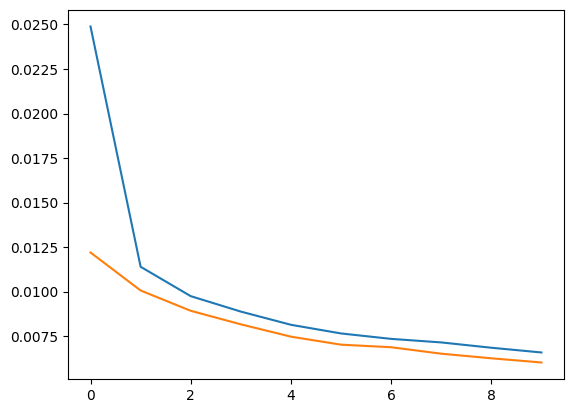

In [9]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [12]:
for key, val in history['train_cr'][-1].items():
  print(key, val)

0 {'precision': 0.9988555823514099, 'recall': 0.9990837654537817, 'f1-score': 0.9989696608722883, 'support': 1221303.0}
1 {'precision': 0.826580226904376, 'recall': 0.43739279588336194, 'f1-score': 0.5720695457094784, 'support': 1166.0}
2 {'precision': 0.9962883375659308, 'recall': 0.9941520467836257, 'f1-score': 0.995219045760562, 'support': 5130.0}
3 {'precision': 0.9982501184815612, 'recall': 0.9974812787194072, 'f1-score': 0.9978655505057604, 'support': 192161.0}
4 {'precision': 1.0, 'recall': 0.09090909090909091, 'f1-score': 0.16666666666666666, 'support': 22.0}
5 {'precision': 0.9832965647652064, 'recall': 0.9981676991536516, 'f1-score': 0.9906763271079294, 'support': 34383.0}
6 {'precision': 0.8791666666666667, 'recall': 0.8300550747442959, 'f1-score': 0.8539053014973695, 'support': 1271.0}
accuracy 0.9982218386792686
macro avg {'precision': 0.9546339281050216, 'recall': 0.763891678806745, 'f1-score': 0.796481728302865, 'support': 1455436.0}
weighted avg {'precision': 0.99815651